In [2]:
from sklearn.decomposition import PCA
import cv2, os
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from scipy import ndimage
import torch

### Data load

In [2]:
munsell_data = loadmat('../dataset/munsell380_800_1.mat')

In [3]:
munsell = munsell_data['munsell']
S = munsell_data['S']
C = munsell_data['C']

# bring only 430 to 660 at 5nm interval
munsell_430_660 = munsell[50:-138][::5]

In [4]:
# plt.plot(munsell[:,0])

### PCA find basis

In [5]:
pca = PCA(n_components=8) 
pca.fit(munsell_430_660.T)

PCA(n_components=8)

In [6]:
coeff = pca.transform(munsell_430_660.T)

In [7]:
munsell_430_660.max(), munsell_430_660.min(), munsell_430_660.mean()

(0.8155, 0.0277, 0.2763169779362205)

In [8]:
diff = abs(munsell_430_660.T - pca.inverse_transform(coeff))
diff.max(), diff.min(), diff.mean()

(0.04320145276627413, 1.1834727853266003e-07, 0.002303229709322819)

In [9]:
diff = abs(munsell_430_660.T - pca.inverse_transform(coeff))
diff.max(), diff.min(), diff.mean()

(0.04320145276627413, 1.1834727853266003e-07, 0.002303229709322819)

In [10]:
pca.components_.shape

(8, 47)

In [11]:
# import pickle
# with open("munsell_basis.pkl", "wb") as file:
#     pickle.dump(pca, file)

### Make hdr

In [3]:
colors = ['white','green','red','blue','cyan','yellow','magenta']
# colors = ['white']

# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

#### IF NEEDED

In [19]:
idx_minmax = 1

# exposure times
ex_time = np.array([160, 320])
ex_min = ex_time[idx_minmax]
exposure = ex_time / ex_min

# rgb intensity
intensity = np.array([0.2, 0.8])

ldr2hdr_dir = "../dataset/data/20231114_procam_real_data/"

last_row_center_pts = np.array([171,432]) # 1105

In [20]:
# safe subtraction for uint16
def safe_subtract(a,b):
    # difference = np.abs(a.astype(np.int16) - b.astype(np.int16))
    
    difference = np.where(a>b, a-b, 0)
    difference = np.clip(np.round(difference), 0, 65535).astype(np.uint16)    
    
    return difference.astype(a.dtype)

In [21]:
# radiance weight for intensity normalization
def cal_radiance_weight(exp_images_bgrm): # exposure 개수, H, W, 3
    radiance_values = np.zeros(shape=(len(exp_images_bgrm), 3))
    
    p_size = 5
    
    for i in range(len(exp_images_bgrm)):
        y_idx_start, y_idx_end = (last_row_center_pts[1] - p_size//2).astype(np.int32), (last_row_center_pts[1] + p_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (last_row_center_pts[0] - p_size//2).astype(np.int32), (last_row_center_pts[0] + p_size//2).astype(np.int32)
        
        radiance_values[i] = exp_images_bgrm[i][y_idx_start:y_idx_end, x_idx_start:x_idx_end].mean(axis = (0,1))
    
    return (radiance_values / radiance_values[idx_minmax])

# calculate radiance_weight
exp_img_path = os.path.join(ldr2hdr_dir, 'intensity_%d_white_crop/calibration00/capture_%04d.png')
exp_img_black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

exp_images = np.array([cv2.imread(exp_img_path%(intensity[k]*100, 0), -1)[:,:,::-1] for k in range(len(intensity))])
exp_black_images = np.array([cv2.imread(exp_img_black_path%(ex_time[0], 0), -1)[:,:,::-1] for k in ex_time])

# remove black image
exp_images_bgrm = safe_subtract(exp_images, exp_black_images)

# radiance weight calculation
radiance_weight = cal_radiance_weight(exp_images_bgrm)

In [22]:
1/radiance_weight

array([[21.36967632, 20.74291206, 21.54874214],
       [ 1.        ,  1.        ,  1.        ]])

In [23]:
invalid_intensity_ratio = 0.01 # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv:
        weight_trapezoid[i] = 0  
    elif i < intv * 2:
        weight_trapezoid[i] = (i - intv) / intv
    elif i < max_intensity - (intv * 2):
        weight_trapezoid[i] = 1
    elif i < max_intensity - intv:
        weight_trapezoid[i] = (max_intensity - intv - i) / intv
    else:
        weight_trapezoid[i] = 0

In [24]:
invalid_intensity_ratio = 0.01  # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**16
weight_trapezoid_bgrm = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv: # 3 
        weight_trapezoid_bgrm[i] = 0  
    elif i < intv * 2:
        weight_trapezoid_bgrm[i] = (i - intv) / intv
    else:
        weight_trapezoid_bgrm[i] = 1

In [25]:
def make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure):

    weighted_images = [weight_trapezoid[image] for image in ldr_images]
    weighted_images_bgrm = [weight_trapezoid_bgrm[image] for image in ldr_images_bgrm]
    
    # take the minimum weight 
    weighted_images_final = np.minimum(weighted_images, weighted_images_bgrm)
    
    # exposure normalization
    radiance_images = [np.multiply(weighted_images_final[i], ldr_images_bgrm[i] / (radiance_weight[i] * exposure[i])) for i in range(len(ldr_images_bgrm))]

    # intensity normalization
    weight_sum_image = np.sum(weighted_images_final, axis=0)
    radiance_sum_image = np.sum(radiance_images, axis=0)

    idx_invalid = (weight_sum_image == 0)
    weight_sum_image[idx_invalid] = 1
    radiance_sum_image[idx_invalid] = 0    
    
    return np.divide(radiance_sum_image, weight_sum_image), idx_invalid, weight_sum_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original :  [4.51764706 8.34509804 5.01960784]
normalized :  [ 96.54065538 173.10163477 108.16623505]
original :  [ 93.11372549 169.16078431 107.60784314]
normalized :  [ 93.11372549 169.16078431 107.60784314]


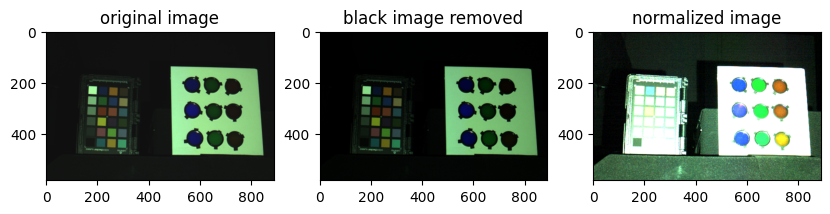

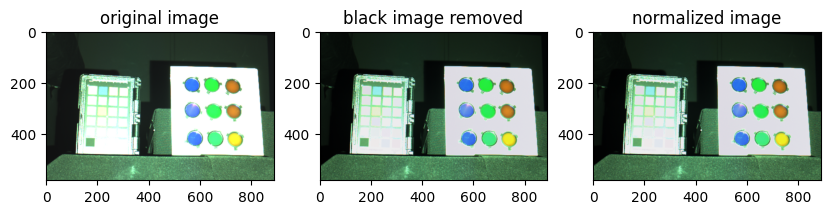

In [26]:
for i in range(len(exp_images)):
    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(exp_images[i]/65535), plt.title('original image')
    plt.subplot(132), plt.imshow((exp_images_bgrm[i]/ 65535)), plt.title('black image removed')
    plt.subplot(133), plt.imshow((exp_images_bgrm[i]*(1/radiance_weight[i]))/ 65535), plt.title('normalized image')
    print('original : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]]/ 255))
    print('normalized : ', (exp_images_bgrm[i][last_row_center_pts[1], last_row_center_pts[0]] * (1/radiance_weight[i]))/ 255)

In [27]:
hdr_imgs = np.zeros(shape = (len(colors), n_illum, cam_H, cam_W, 3))

# erase black image and get hdr image
for c in range(len(colors)):
    for i in range(n_illum):    
        ldr_path = os.path.join(ldr2hdr_dir, 'step2_%sms_%s_crop/calibration00/capture_%04d.png')
        black_path = os.path.join(ldr2hdr_dir, 'step2_%sms_black_crop/calibration00/capture_%04d.png')

        ldr_images = np.array([cv2.imread(ldr_path%(k, colors[c], i), -1)[:,:,::-1] for k in ex_time])
        ldr_black_images = np.array([cv2.imread(black_path%(k, 0), -1)[:,:,::-1] for k in ex_time])
                
        ldr_images_bgrm = np.clip(safe_subtract(ldr_images, ldr_black_images), 0., 2**16)
        ldr_images_bgrm = ldr_images_bgrm.astype(np.uint16)
        
        # print(final_ldr_images.max(), final_ldr_images.min())
            
        hdr_img, invalid_map, weight_map = make_hdr(ldr_images, ldr_images_bgrm, weight_trapezoid, exposure)
        hdr_imgs[c,i] = hdr_img

        if i % 10 == 0:
            print('%03d-th finished'%i)
    print('color %s finished'%colors[c])

    hdr_imgs = np.array(hdr_imgs)

000-th finished
010-th finished
020-th finished
030-th finished
040-th finished
050-th finished
060-th finished
070-th finished
080-th finished
090-th finished
100-th finished
110-th finished
120-th finished
130-th finished
140-th finished
150-th finished
160-th finished
170-th finished
180-th finished
190-th finished
200-th finished
210-th finished
220-th finished
230-th finished
240-th finished
250-th finished
260-th finished
270-th finished
280-th finished
290-th finished
300-th finished
310-th finished
color white finished
000-th finished
010-th finished
020-th finished
030-th finished
040-th finished
050-th finished
060-th finished
070-th finished
080-th finished
090-th finished
100-th finished
110-th finished
120-th finished
130-th finished
140-th finished
150-th finished
160-th finished
170-th finished
180-th finished
190-th finished
200-th finished
210-th finished
220-th finished
230-th finished
240-th finished
250-th finished
260-th finished
270-th finished
280-th finished
290

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


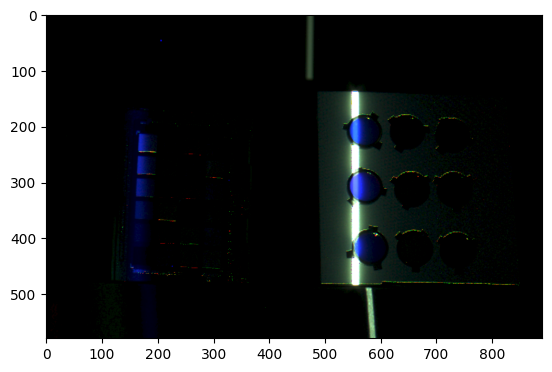

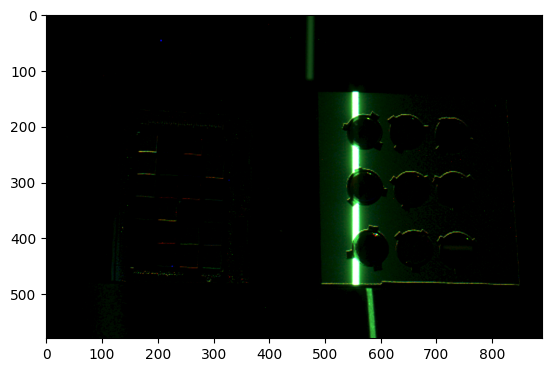

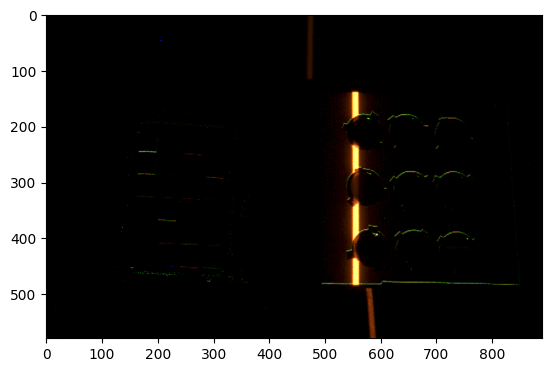

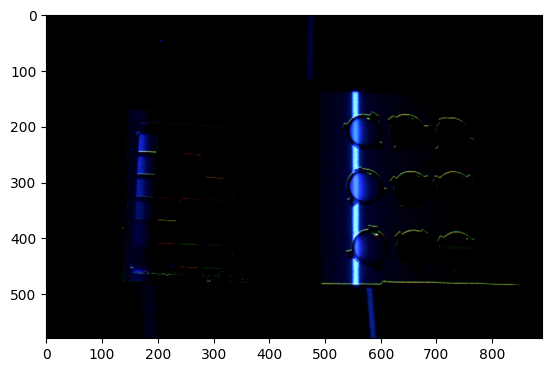

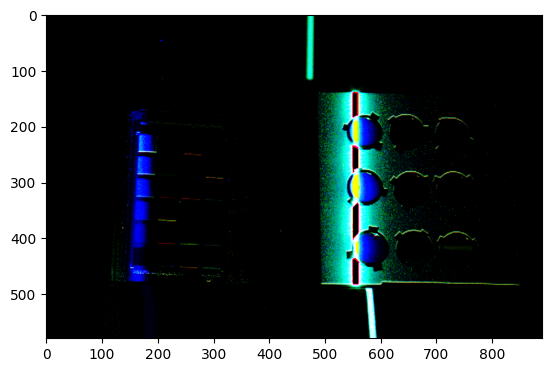

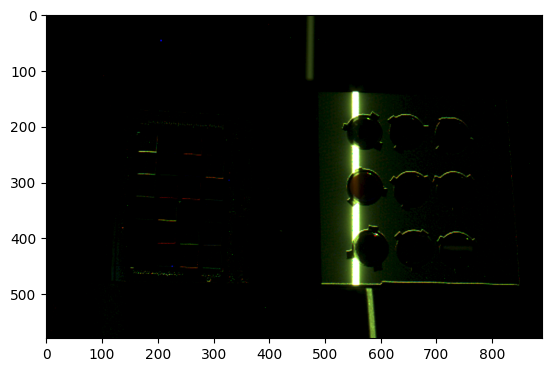

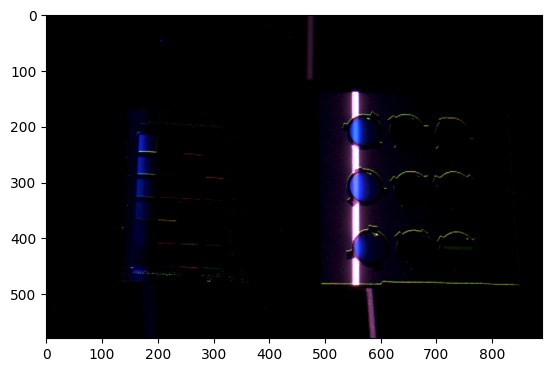

In [28]:
idx = 200
max_val = 65535

for c in range(len(colors)):
    fig, ax = plt.subplots()
    ax.imshow((hdr_imgs[c,idx] / (70000))**(1/1.5))

In [29]:
hdr_imgs.shape

(7, 318, 580, 890, 3)

### Iterative Optimization

In [4]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

depth_start = 600
depth_end = 900     
depth_arange = np.arange(depth_start, depth_end + 1, 1)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

real_data_dir = "../dataset/data/20231114_procam_real_data/"

#### PEF, CRF, DG Efficiency

In [5]:
PEF = np.load('../dataset/image_formation/PEF_update_1113.npy')
CRF = np.load('../dataset/image_formation/CRF_update_1113.npy') # from 430nm
DG_efficiency = np.load('../dataset/image_formation/DG_update_1113.npy') # from 430nm

new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

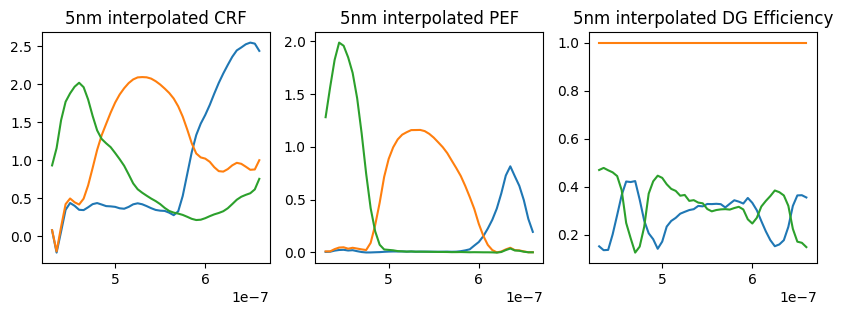

In [33]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

In [27]:
scalar = np.ones(shape=(47,))
scalar[0:3] = 1.8
scalar[3] = 1.5
scalar[4] = 1.2
scalar[5:12] = 0.75

#### Median filter

In [34]:
hdr_imgs_filtered_array = np.zeros(shape = (len(colors), n_illum, cam_H, cam_W, 3))

for c in range(len(colors)):
    hdr_imgs_color = hdr_imgs[c] / 65535
    # median filter
    hdr_imgs_filtered_R = np.array([ndimage.median_filter(image[:,:,0], size=4) for image in hdr_imgs_color])
    hdr_imgs_filtered_G = np.array([ndimage.median_filter(image[:,:,1], size=4) for image in hdr_imgs_color])
    hdr_imgs_filtered_B = np.array([ndimage.median_filter(image[:,:,2], size=4) for image in hdr_imgs_color])

    hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

    hdr_imgs_filtered_array[c] = hdr_imgs_filtered
    print('%s color finished'%colors[c])

white color finished
green color finished
red color finished
blue color finished
cyan color finished
yellow color finished
magenta color finished


In [36]:
np.save('hdr_imgs_filtered_array.npy', hdr_imgs_filtered_array)

In [30]:
efef

NameError: name 'efef' is not defined

#### Hdr_imgs

In [37]:
hdr_imgs = np.load('./hdr_imgs_filtered_array.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


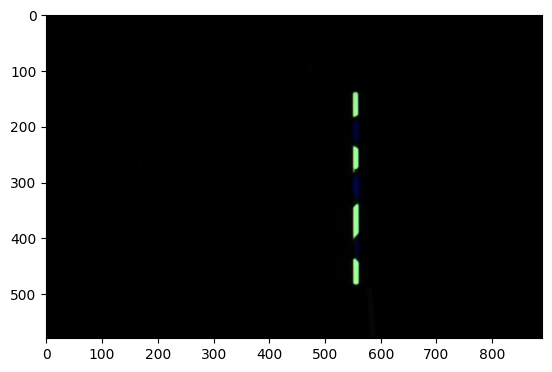

In [43]:
c_idx = 0
illum_idx = 200
plt.imshow(hdr_imgs[c_idx,illum_idx]/24)

#### Depth

In [45]:
depth = np.load(os.path.join(real_data_dir,'20231114_procam_depth.npy'))[:,:,2]*1e+3

(<matplotlib.image.AxesImage at 0x1e8f413c548>,
 <matplotlib.colorbar.Colorbar at 0x1e8f4171148>)

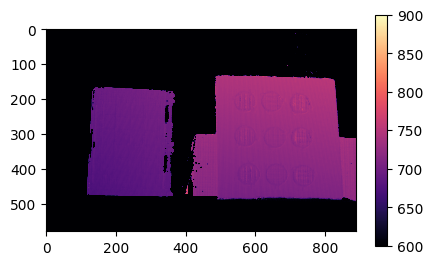

In [46]:
plt.figure(figsize=(5,3))
plt.imshow(depth, vmin=600, vmax = 900, cmap='magma'), plt.colorbar()

In [47]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

#### Depth dependent peak illumination index

In [6]:
first_illum_idx = np.load(('../dataset/image_formation/20231007/npy_data/first_illum_idx_final_transp.npy'))
Mask = np.load('../dataset/image_formation/20231007/npy_data/Mask.npy')

In [49]:
first_illum_idx = first_illum_idx.reshape(len(depth_arange), len(new_wvls), cam_H*cam_W)

In [50]:
first_illum_idx[first_illum_idx >= 318] = 317
first_illum_idx[first_illum_idx < 0 ] = 0

In [51]:
zero_illum_idx_wo_depth = np.zeros(shape=(len(colors), cam_H * cam_W))
hdr_imgs_reshape = hdr_imgs.reshape(len(colors), n_illum, cam_H*cam_W, 3)

for c in range(len(colors)):
    for i in range(cam_H*cam_W):
        max_idx = np.argmax(hdr_imgs_reshape[c,:,i].mean(axis = 1))
        zero_illum_idx_wo_depth[c, i] = max_idx

zero_illum_idx_wo_depth = np.round(zero_illum_idx_wo_depth)
zero_illum_idx = np.repeat(zero_illum_idx_wo_depth.reshape(len(colors), 1, 1, cam_H*cam_W), len(depth_arange), axis=1)

print(zero_illum_idx.shape) # (7, 301, 1, 516200)

(7, 301, 1, 516200)


In [52]:
# Choose valid idx
zero_real_img_illum_idx = np.zeros(shape=(len(colors), 1, cam_H*cam_W))

for c in range(len(colors)):
    for i in range(cam_H*cam_W):
        if (depth[i] < 600) or (depth[i] > 900):
            depth[i] = 600
        depth_idx = np.where(depth_arange == depth[i])[0][0]
        zero_real_img_illum_idx[c,:,i] = zero_illum_idx[c, depth_idx, :, i]

zero_real_img_illum_idx = zero_real_img_illum_idx.astype(np.int16).reshape(len(colors), 1, cam_H, cam_W)
zero_real_img_illum_idx_final = np.stack((zero_real_img_illum_idx, zero_real_img_illum_idx, zero_real_img_illum_idx), axis = 4)

print(zero_real_img_illum_idx_final.shape)

(7, 1, 580, 890, 3)


In [53]:
DG_efficiency_image_zero = np.ones(shape=(cam_H * cam_W, len(new_wvls)))

In [54]:
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

GT_I_RGB_ZERO = np.zeros(shape=(len(colors), cam_H, cam_W, 1, 3))
for c in range(len(colors)):
    GT_I_RGB_ZERO[c] =  hdr_imgs[c][zero_real_img_illum_idx_final[c], x, y, z].transpose(1, 2, 0, 3)

In [55]:
patt_colors = np.zeros(shape=(len(colors), cam_H* cam_W, 3))
constant = 0.8

for c_idx, c in enumerate(colors):
    if c == 'white':
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 1 * constant
        
    elif c== 'green':
        patt_colors[c_idx,:,0] = 0 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 0 * constant

    elif c== 'red':
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 0 * constant
        patt_colors[c_idx,:,2] = 0 * constant

    elif c== 'blue':
        patt_colors[c_idx,:,0] = 0 * constant
        patt_colors[c_idx,:,1] = 0 * constant
        patt_colors[c_idx,:,2] = 1 * constant

    elif c== 'cyan':
        patt_colors[c_idx,:,0] = 0 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 1 * constant

    elif c== 'yellow':
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 0 * constant

    else:        
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 0 * constant
        patt_colors[c_idx,:,2] = 1 * constant

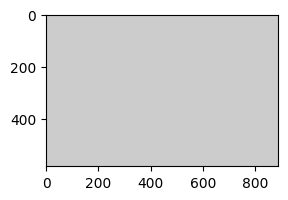

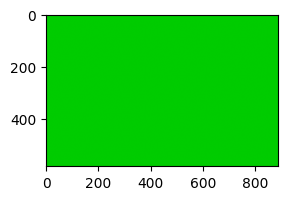

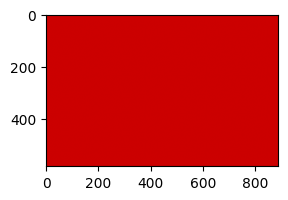

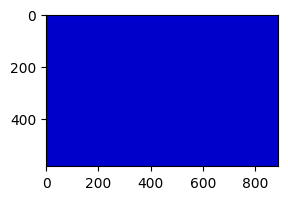

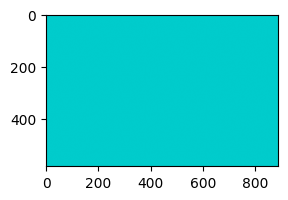

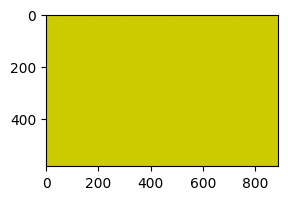

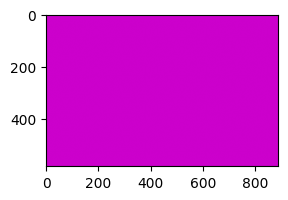

In [56]:
for c in range(len(colors)):
    plt.figure(figsize=(3,2))
    plt.imshow(patt_colors[c].reshape(cam_H, cam_W, 3))

In [51]:
START OPTIMIZATION

SyntaxError: invalid syntax (2240033188.py, line 1)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:36: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)


Epoch : 0/600, Loss: 16.308396047323395, LR: 0.08


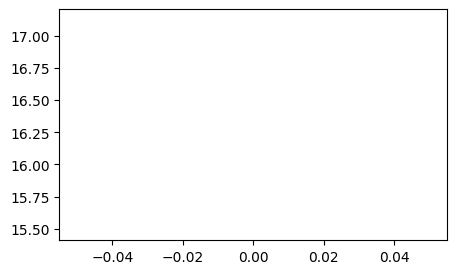

Epoch : 10/600, Loss: 8.638961413358237, LR: 0.08
Epoch : 20/600, Loss: 6.391053147554521, LR: 0.08
Epoch : 30/600, Loss: 4.6777815956323145, LR: 0.08
Epoch : 40/600, Loss: 3.7709352087591146, LR: 0.08
Epoch : 50/600, Loss: 3.5773045604317284, LR: 0.08
Epoch : 60/600, Loss: 3.34380004290081, LR: 0.08
Epoch : 70/600, Loss: 3.233288734619561, LR: 0.08
Epoch : 80/600, Loss: 3.1410844265772417, LR: 0.08
Epoch : 90/600, Loss: 3.0812730923201093, LR: 0.08
Epoch : 100/600, Loss: 3.043986631392547, LR: 0.08


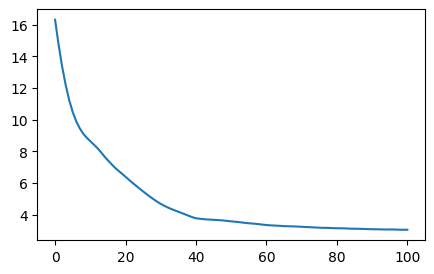

Epoch : 110/600, Loss: 3.02249206669168, LR: 0.08
Epoch : 120/600, Loss: 3.0153364873933644, LR: 0.08
Epoch : 130/600, Loss: 3.004667222617612, LR: 0.08
Epoch : 140/600, Loss: 3.007744623315721, LR: 0.08
Epoch : 150/600, Loss: 3.010058431866015, LR: 0.08
Epoch : 160/600, Loss: 3.007575310837056, LR: 0.08
Epoch : 170/600, Loss: 3.006184224502241, LR: 0.08
Epoch : 180/600, Loss: 3.0048805627444146, LR: 0.08
Epoch : 190/600, Loss: 3.0071597171570947, LR: 0.08
Epoch : 200/600, Loss: 3.0115664963837063, LR: 0.04


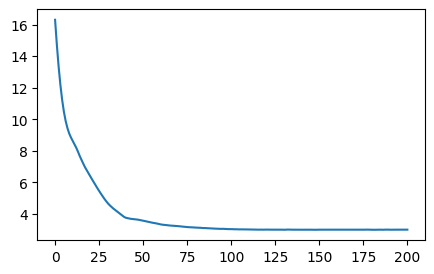

Epoch : 210/600, Loss: 2.9970664829579854, LR: 0.04
Epoch : 220/600, Loss: 2.9963578854116673, LR: 0.04
Epoch : 230/600, Loss: 2.9961658864174594, LR: 0.04
Epoch : 240/600, Loss: 3.001481224321188, LR: 0.04
Epoch : 250/600, Loss: 2.9967960982745923, LR: 0.04
Epoch : 260/600, Loss: 2.993724707122234, LR: 0.04
Epoch : 270/600, Loss: 2.9962123446598654, LR: 0.04
Epoch : 280/600, Loss: 2.9936478163568454, LR: 0.04
Epoch : 290/600, Loss: 2.996241763909094, LR: 0.04
Epoch : 300/600, Loss: 2.993918033728408, LR: 0.04


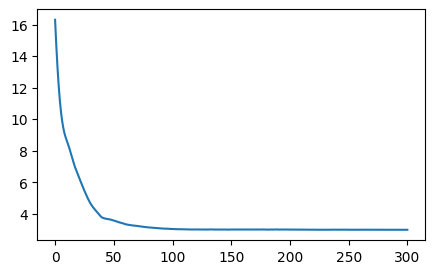

Epoch : 310/600, Loss: 2.9947185663651377, LR: 0.04
Epoch : 320/600, Loss: 2.999125687951948, LR: 0.04
Epoch : 330/600, Loss: 2.9967953480310854, LR: 0.04
Epoch : 340/600, Loss: 3.001514087481818, LR: 0.04
Epoch : 350/600, Loss: 2.994969075105642, LR: 0.04
Epoch : 360/600, Loss: 2.9990417524869493, LR: 0.04
Epoch : 370/600, Loss: 2.9987865490049765, LR: 0.04
Epoch : 380/600, Loss: 2.997873723087389, LR: 0.04
Epoch : 390/600, Loss: 2.9987564943459635, LR: 0.04
Epoch : 400/600, Loss: 2.996944175864347, LR: 0.02


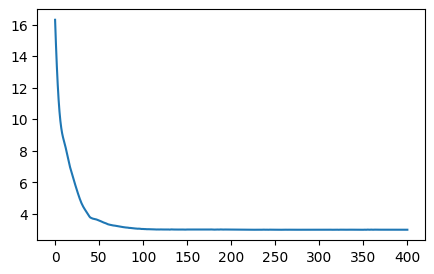

Epoch : 410/600, Loss: 2.992001139349044, LR: 0.02
Epoch : 420/600, Loss: 2.9920998377370776, LR: 0.02
Epoch : 430/600, Loss: 2.9910409312981443, LR: 0.02
Epoch : 440/600, Loss: 2.9917676703487617, LR: 0.02
Epoch : 450/600, Loss: 2.9917563384110033, LR: 0.02
Epoch : 460/600, Loss: 2.991598604618468, LR: 0.02
Epoch : 470/600, Loss: 2.991808684507661, LR: 0.02
Epoch : 480/600, Loss: 2.990885363938618, LR: 0.02
Epoch : 490/600, Loss: 2.9904765820742067, LR: 0.02
Epoch : 500/600, Loss: 2.9917805356764924, LR: 0.02


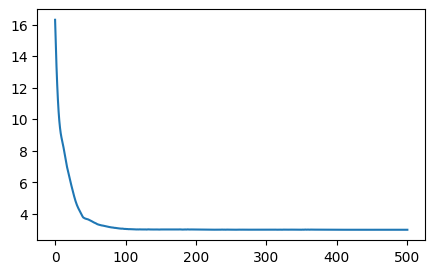

Epoch : 510/600, Loss: 2.990949516432032, LR: 0.02
Epoch : 520/600, Loss: 2.991413914679698, LR: 0.02
Epoch : 530/600, Loss: 2.9927898208657084, LR: 0.02
Epoch : 540/600, Loss: 2.9922953821961977, LR: 0.02
Epoch : 550/600, Loss: 2.991351053690098, LR: 0.02
Epoch : 560/600, Loss: 2.992973139640249, LR: 0.02
Epoch : 570/600, Loss: 2.9909145253437153, LR: 0.02
Epoch : 580/600, Loss: 2.992176921149725, LR: 0.02
Epoch : 590/600, Loss: 2.991750578750259, LR: 0.02


In [57]:
import random
# arguments
device = 'cuda:0'
epoch = 600 #2000
loss_f = torch.nn.L1Loss()
losses = [] 

# Height, width of image
H, W = 1, 1

# learning rate & decay step
lr = 0.08 # 0.03
decay_step = 200
gamma = 0.5

# initial_value = torch.ones(size =(cam_H*cam_W, len(new_wvls)))/2
initial_value = torch.ones(size =(cam_H*cam_W, pca.components_.shape[0]))/2
_opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# basis vector
basis = torch.tensor(pca.components_, dtype = torch.float).to(device).unsqueeze(dim = 0)

# optimizer and schedular
optimizer = torch.optim.Adam([_opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device)
DG_efficiency_zero_dev = torch.tensor(DG_efficiency_image_zero.reshape(cam_H*cam_W, -1), device=device)

# depth scalar
A =  2.5 * 1e+5 # 10 * 1e+5 for peak # 4 * 1e+5 for tree
depth_scalar = ((depth.astype(np.int32))**2) / A

depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T
# depth_scalar_dev = torch.ones_like(depth_scalar_dev, dtype = torch.float)

# white pattern into multi-spectral channels
patt_colors_dev = torch.tensor(patt_colors, dtype = torch.float, device=device)
patt_colors_hyp = patt_colors_dev @ PEF_dev
# patt_colors_hyp = patt_colors_hyp.squeeze()

GT_I_RGB_ZERO_tensor = torch.tensor(GT_I_RGB_ZERO, device=device)

rand_idx = [random.randint(0, 21) for _ in range(5)]

weight_spectral = 30 # 50

loss_vis = []
pcamean = torch.tensor(pca.mean_, device=device, dtype=torch.float)
for i in range(epoch):
    # initial loss
    loss = 0

    # opt_param = _opt_param.unsqueeze(dim = -1)
    
    # PCA
    opt_param = _opt_param.unsqueeze(dim = -1)
    ref = (torch.mm(opt_param[...,0], basis[0]) + pcamean).unsqueeze(dim=-1)
    
    for c in range(len(colors)):
        # white pattern into multi-spectral channels
        patt_hyp = patt_colors_hyp[c]
        
        A_zero = CRF_dev.unsqueeze(dim = 0) * patt_hyp.unsqueeze(dim = -1) * DG_efficiency_zero_dev.unsqueeze(dim = -1)
        
        # PCA
        Simulated_I_RGB_zero = torch.sum(ref * A_zero / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1), axis=1) 
        
        zero_loss = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor[c]) / (cam_H*cam_W)
        loss +=  zero_loss.sum()
        
        hyp_dL2 = ((ref[:,:-1] - ref[:,1:])**2).sum()/(cam_H*cam_W)
        loss += weight_spectral*(hyp_dL2)

    loss = loss.sum() / len(colors)
    loss_vis.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
        
    if i % 10 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
        
        if i % 100 == 0:
            plt.figure(figsize=(5,3))
            plt.plot(loss_vis)
            plt.show()

#### Not pca

In [106]:
# import random
# # arguments
# device = 'cuda:0'
# epoch = 600 #2000
# loss_f = torch.nn.L1Loss()
# losses = [] 

# # Height, width of image
# H, W = 1, 1

# # learning rate & decay step
# lr = 0.08 # 0.03
# decay_step = 150
# gamma = 0.5

# initial_value = torch.ones(size =(cam_H*cam_W, len(new_wvls)))/2
# _opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# # basis vector
# basis = torch.tensor(pca.components_, dtype = torch.float).to(device).unsqueeze(dim = 0)

# # optimizer and schedular
# optimizer = torch.optim.Adam([_opt_param], lr = lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# # shape : 3, 47
# PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
# CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device)
# DG_efficiency_zero_dev = torch.tensor(DG_efficiency_image_zero.reshape(cam_H*cam_W, -1), device=device)

# # depth scalar
# A =  3.5 * 1e+5 # 10 * 1e+5 for peak # 4 * 1e+5 for tree
# depth_scalar = ((depth.astype(np.int32))**2) / A

# depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T

# # white pattern into multi-spectral channels
# patt_colors_dev = torch.tensor(patt_colors, dtype = torch.float, device=device)
# patt_colors_hyp = patt_colors_dev @ PEF_dev
# # patt_colors_hyp = patt_colors_hyp.squeeze()

# GT_I_RGB_ZERO_tensor = torch.tensor(GT_I_RGB_ZERO, device=device)

# rand_idx = [random.randint(0, 21) for _ in range(5)]

# weight_spectral = 2 # 50

# loss_vis = []

# for i in range(epoch):
#     # initial loss
#     loss = 0

#     opt_param = _opt_param.unsqueeze(dim = -1)

#     for c in range(len(colors)):
#         # white pattern into multi-spectral channels
#         patt_hyp = patt_colors_hyp[c]
        
#         A_zero = CRF_dev.unsqueeze(dim = 0) * patt_hyp.unsqueeze(dim = -1) * DG_efficiency_zero_dev.unsqueeze(dim = -1)
                
#         Simulated_I_RGB_zero = torch.sum(opt_param * A_zero / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1), axis=1) 

#         zero_loss = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor[c]) / (cam_H*cam_W)
#         loss +=  zero_loss.sum()
        
#         hyp_dL2 = ((opt_param[:,:-1] - opt_param[:,1:])**2).sum()/(cam_H*cam_W)
#         loss += weight_spectral*(hyp_dL2)

#     loss = loss.sum() / len(colors)
#     loss_vis.append(loss.item())
    
#     optimizer.zero_grad()
#     loss.backward()
#     losses.append(loss.item())
#     optimizer.step()
#     scheduler.step()
        
#     if i % 10 == 0:
#         print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
        
#         if i % 100 == 0:
#             plt.figure(figsize=(5,3))
#             plt.plot(loss_vis)
#             plt.show()

### Visualization

In [62]:
opt_param_detach = opt_param.detach().cpu().numpy()
basis_detach = basis.detach().cpu().numpy()

In [63]:
ref = pca.inverse_transform(opt_param_detach[...,0])

In [9]:
ref = np.load('../procam_ssfm_ref.npy')

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


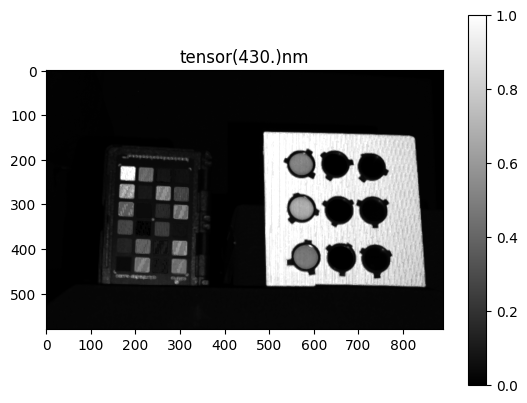

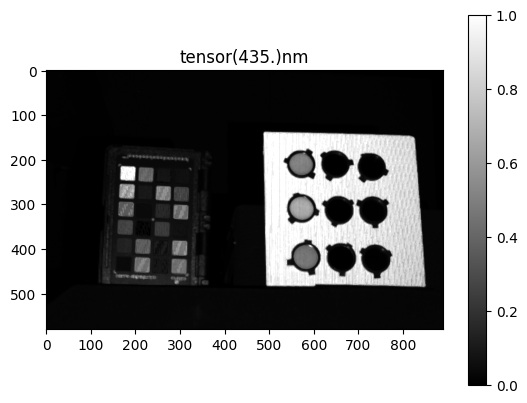

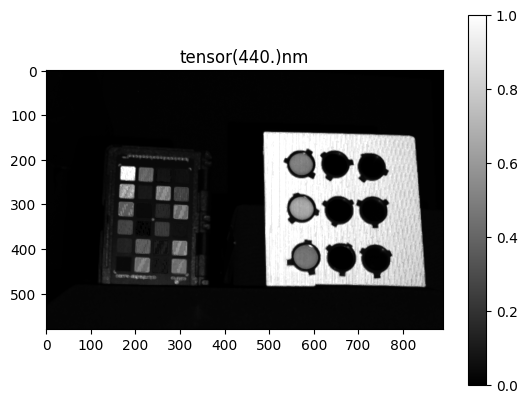

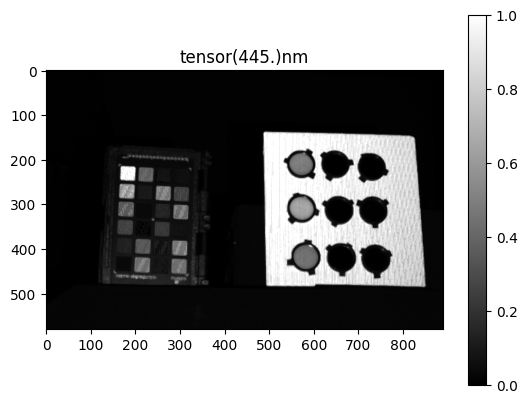

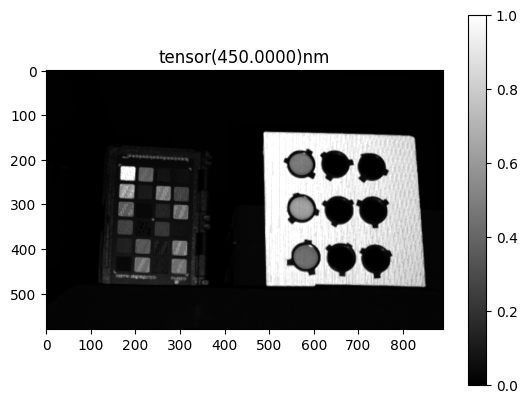

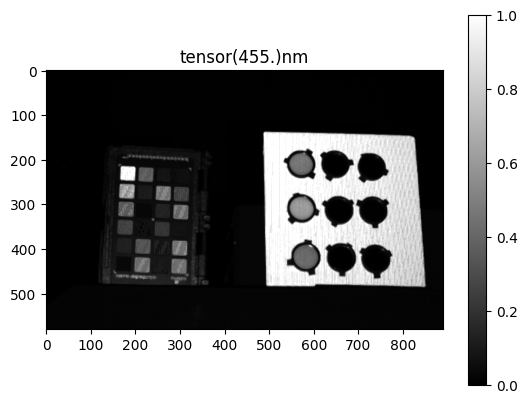

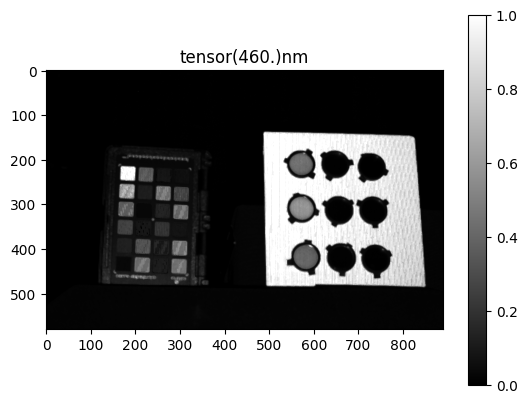

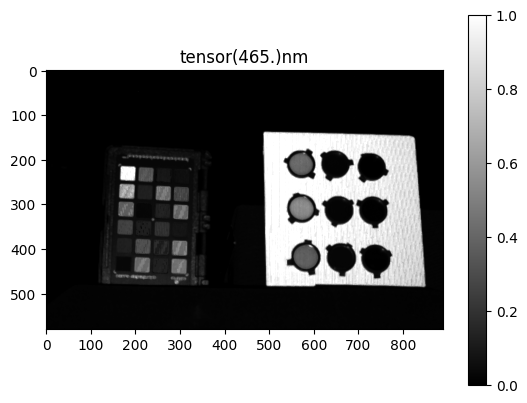

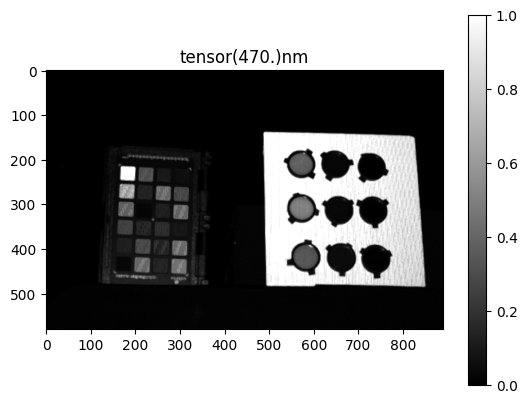

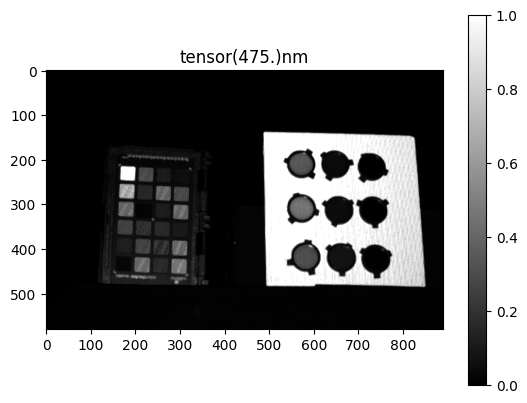

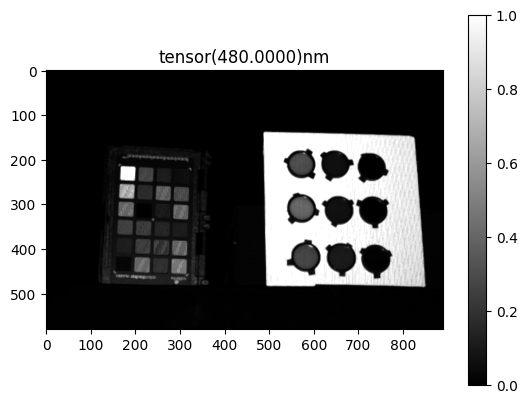

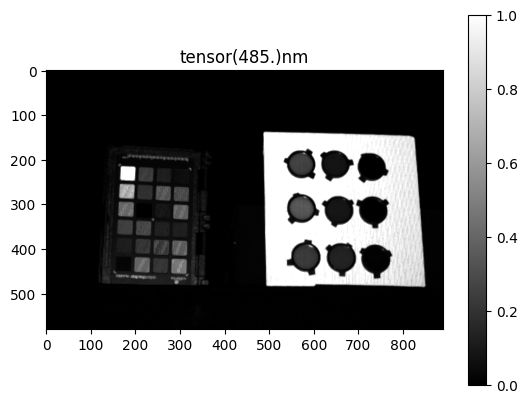

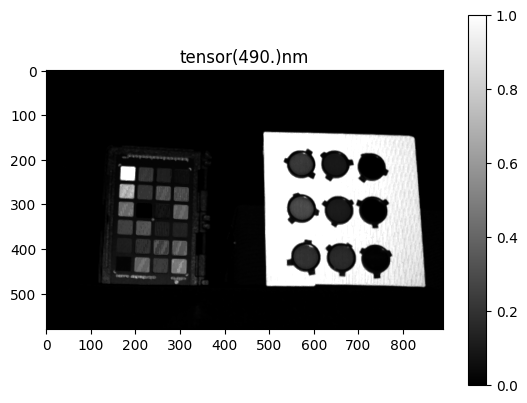

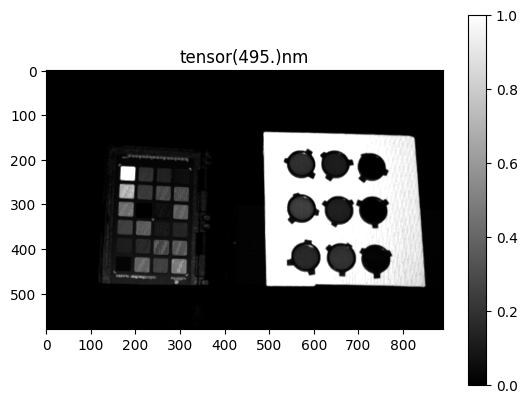

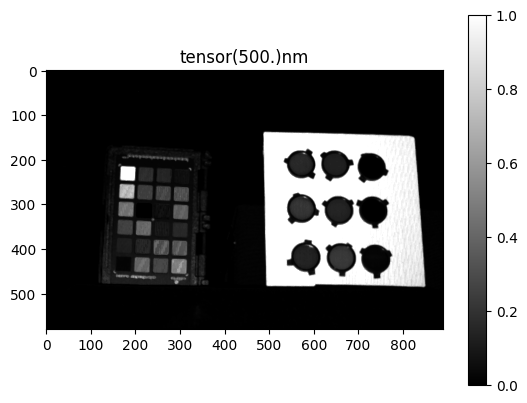

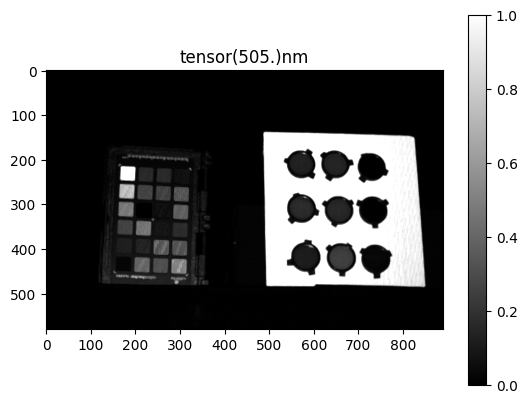

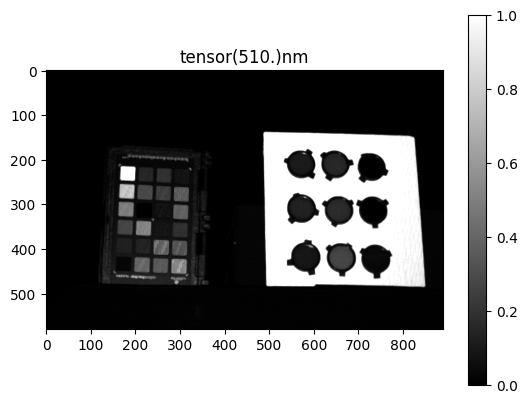

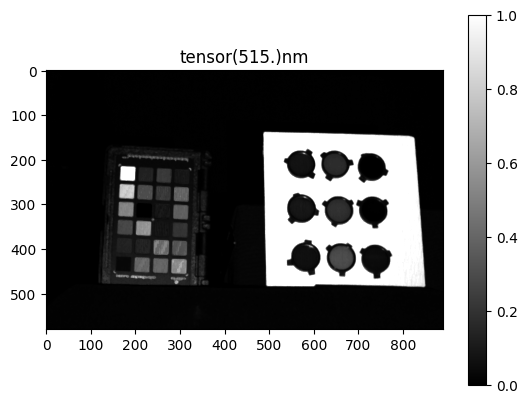

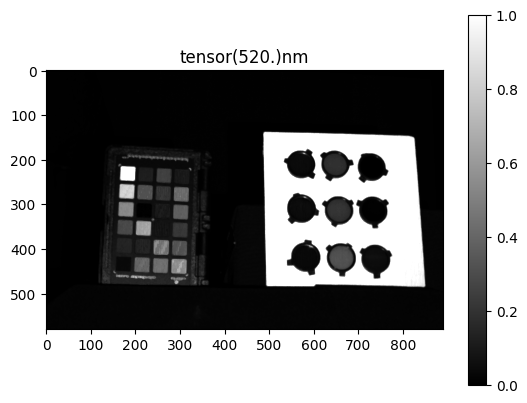

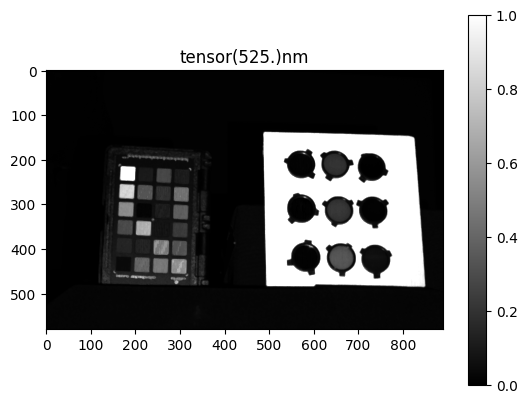

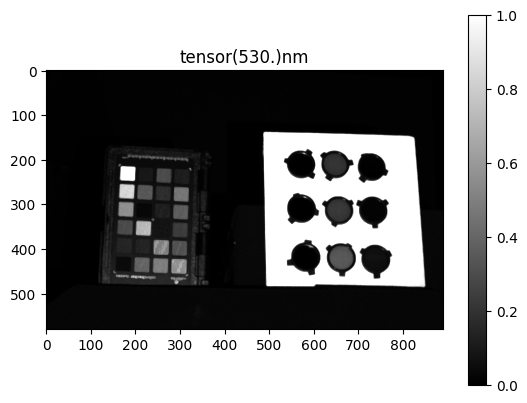

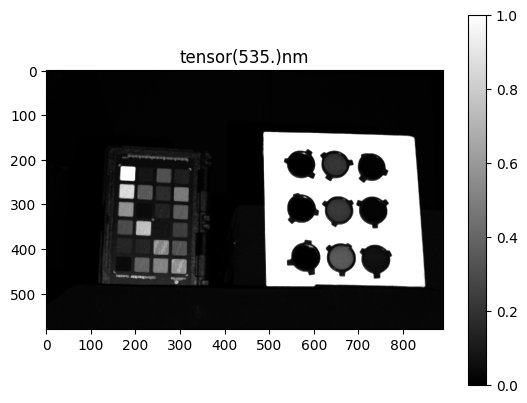

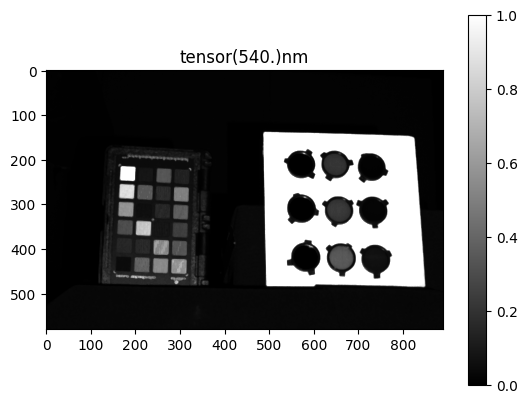

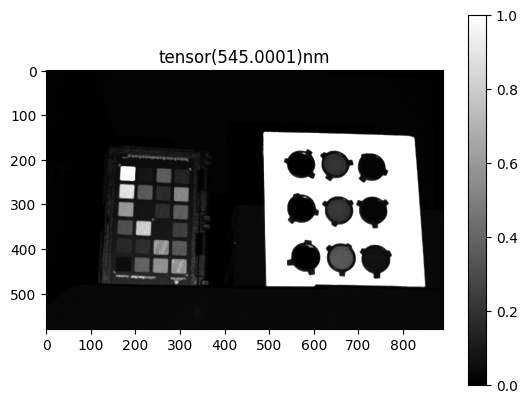

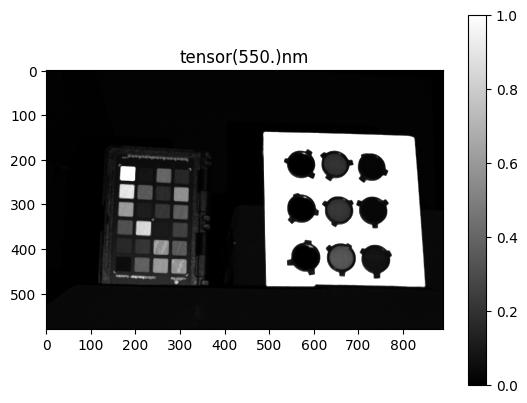

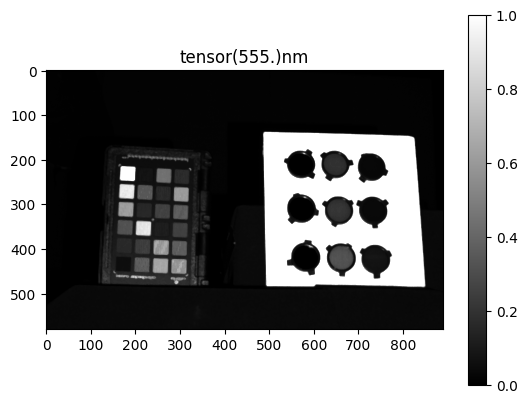

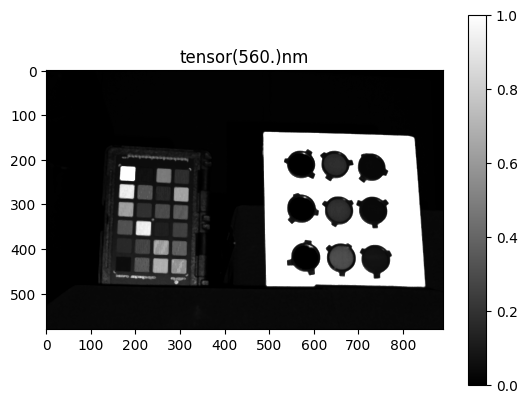

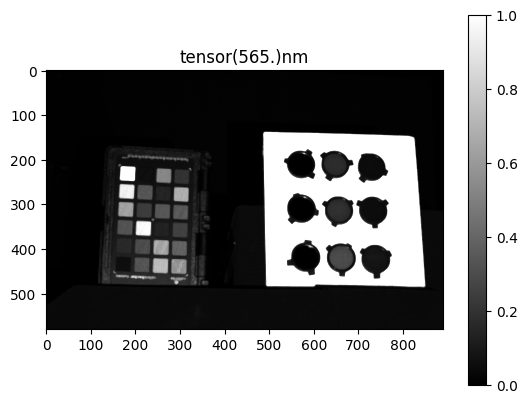

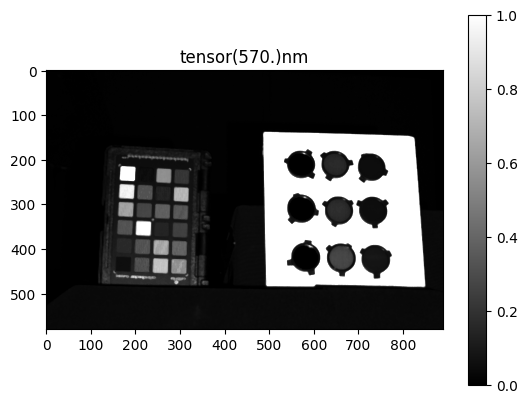

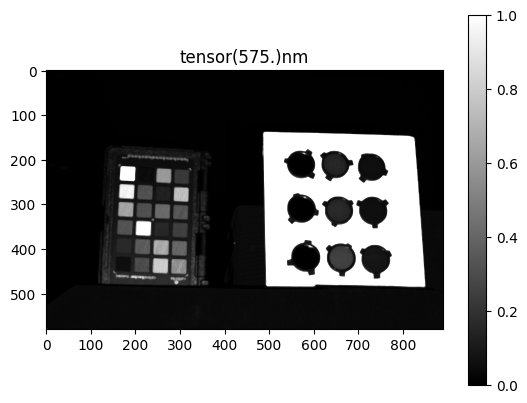

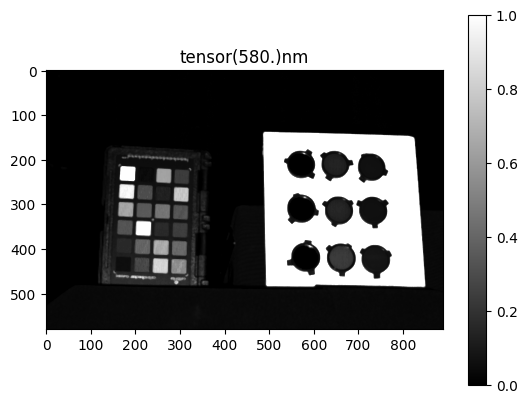

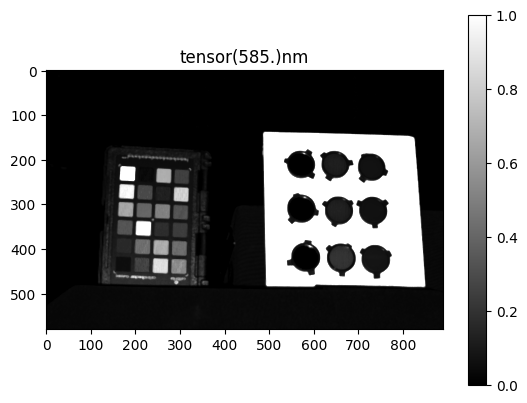

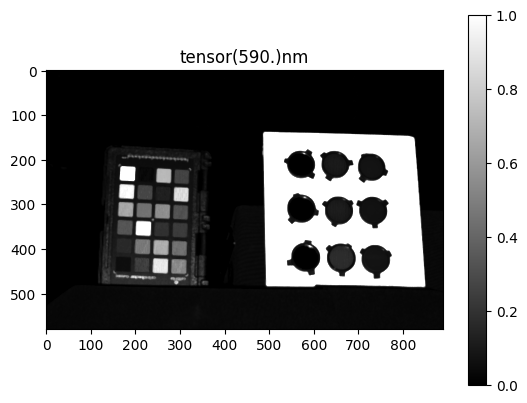

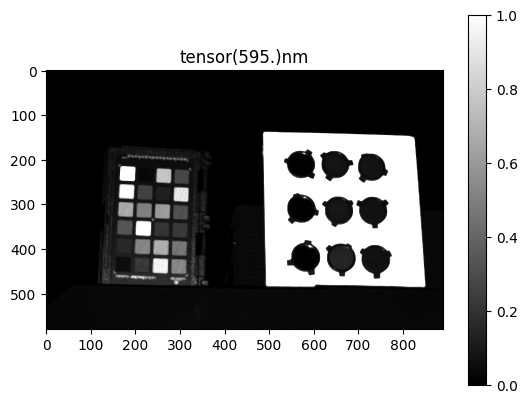

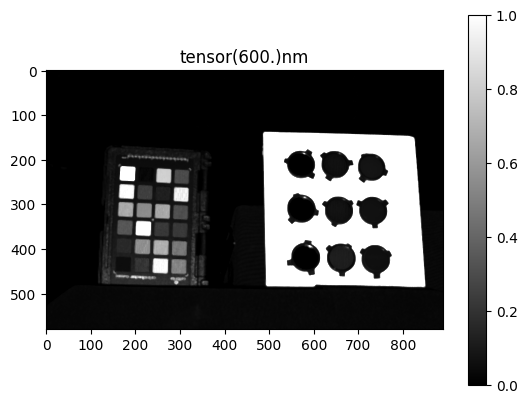

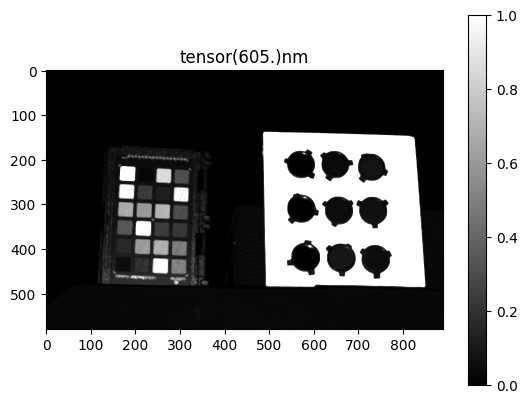

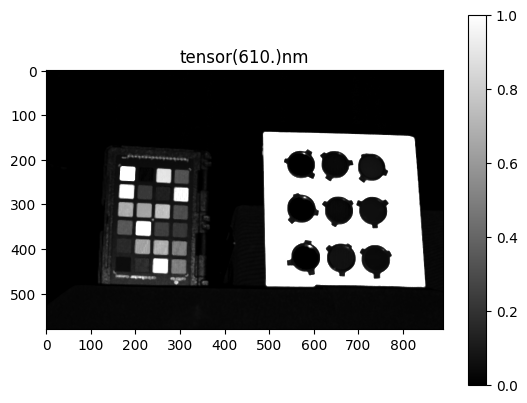

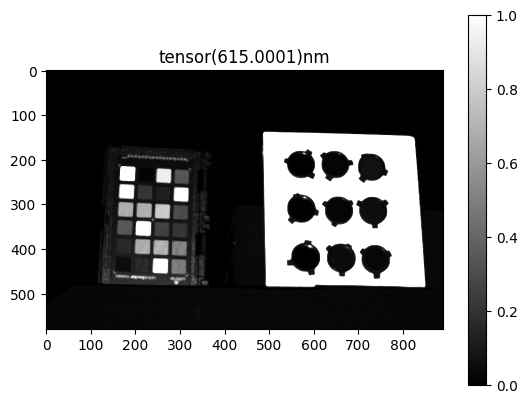

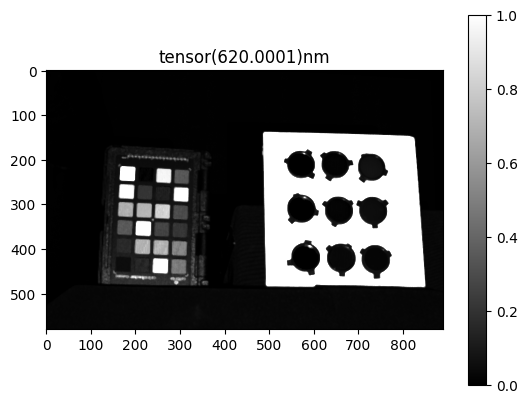

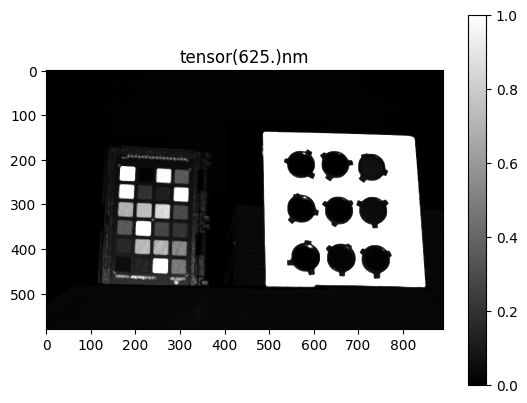

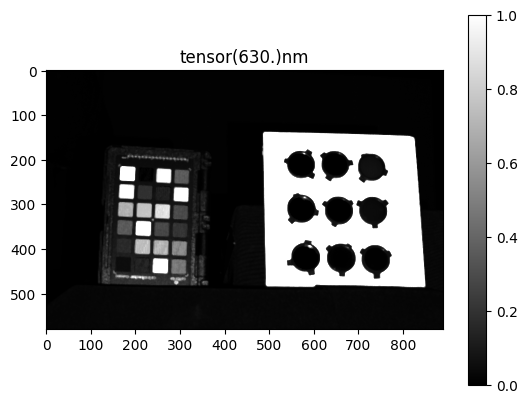

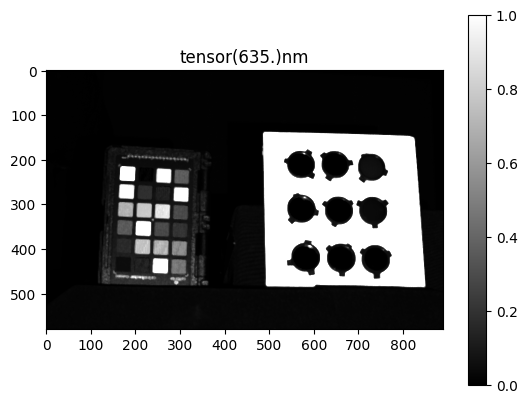

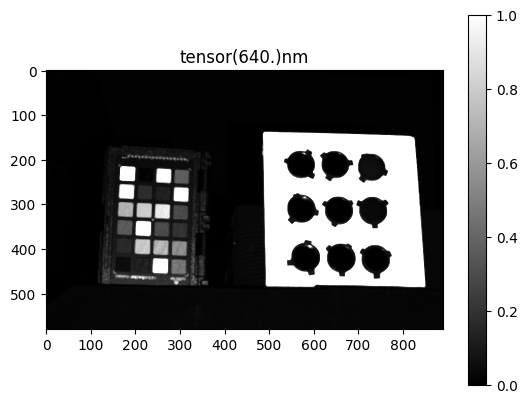

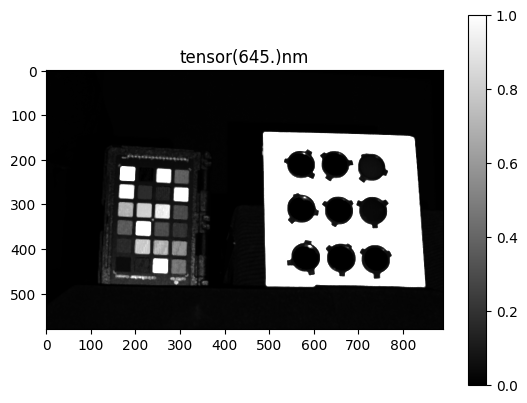

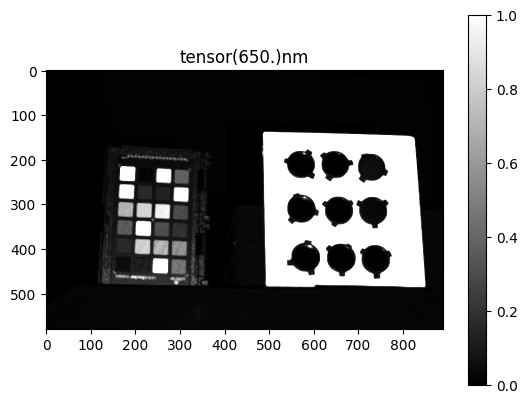

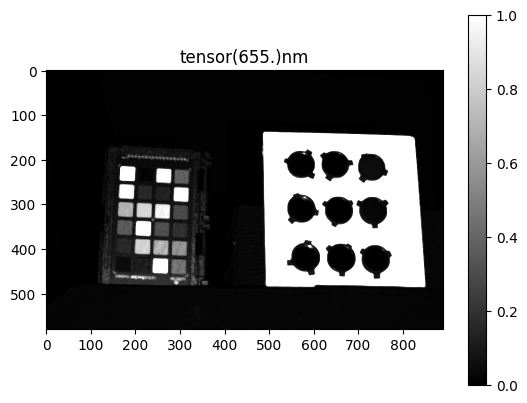

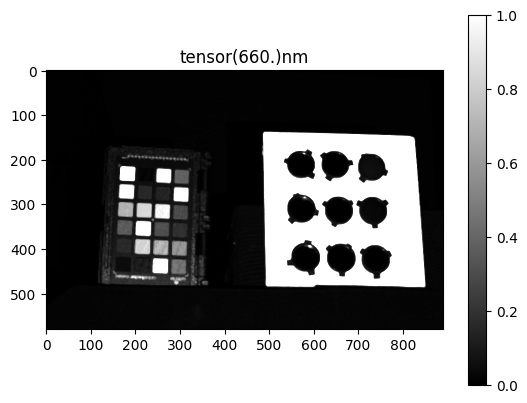

In [13]:
for i in range(len(new_wvls)):
    plt.figure()
    if i < 35:
        plt.imshow(ref.reshape(cam_H, cam_W, len(new_wvls))[:,:,i], vmin = 0, vmax = 1, cmap = 'gray'), plt.title('%snm'%(new_wvls[i]*1e9)), plt.colorbar()
    else:
        plt.imshow(ref.reshape(cam_H, cam_W, len(new_wvls))[:,:,i], vmin = 0, vmax = 1, cmap = 'gray'), plt.title('%snm'%(new_wvls[i]*1e9)), plt.colorbar()


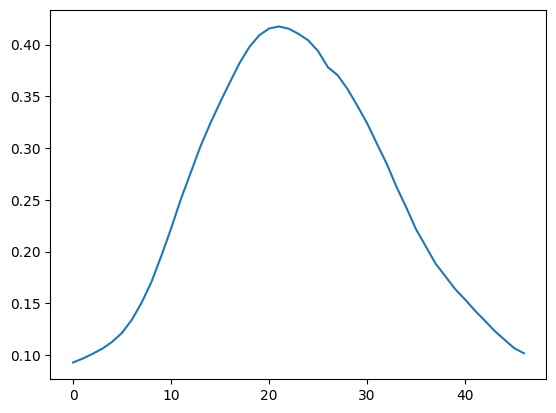

In [115]:
# plt.ylim([0,1])
plt.plot(ref.reshape(cam_H, cam_W, -1)[251,750,:])

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


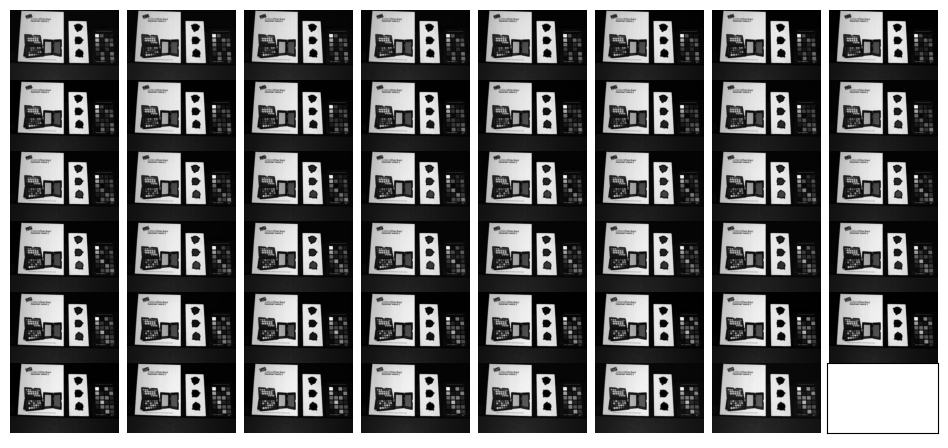

In [111]:
# Set the dimensions of the grid
nrows = 6
ncols = 8

# Create a figure to hold the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5.5),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw={'hspace': 0.00, 'wspace': 0.05})


# Flatten the axes array for easy iteration
axes = axes.ravel()

for i in range(47):
    # Plot image on corresponding subplot
    axes[i].imshow((ref.reshape(cam_H, cam_W, -1)[:,:,i]), cmap = 'gray')  # Use cmap='gray' if your images are grayscale

    axes[i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

### Peak plotting

In [123]:
ref_reshape = ref.reshape(cam_H, cam_W, len(new_wvls))

In [124]:
np.save('procam_ssfm_ref.npy', ref_reshape)

In [117]:
band_pass_transmission = np.load('../dataset/band_pass_transmission.npy')

In [118]:
x_axis = np.arange(430, 661, 50)
c = ['red', 'green', 'blue']
peak_wvl = np.array([570, 560, 550])
all_patches_center_pts = np.array([[557,146], [560,254], [566,350]])

In [119]:
i = 2
max_val = ref_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]].max()
data= ref_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]] / max_val

# data =  band_pass_transmission[i]/band_pass_transmission[i].max()

data =  PEF[:,1]/PEF[:,1].max()

# Step 1: Find the max value and its index
max_value = np.max(data)
max_index = np.argmax(data)

# Step 2: Half max value
half_max = max_value / 2

# Step 3 and 4: Find indices where value is half max and calculate FWHM
fwhm_start = np.argmin(np.abs(data[:max_index] - half_max))
fwhm_end = np.argmin(np.abs(data[max_index:] - half_max)) + max_index

# Calculate the FWHM
fwhm = (fwhm_end - fwhm_start) *5

print(f"FWHM: {fwhm}")

FWHM: 95


570nm tensor(540.)
560nm tensor(540.)
550nm tensor(540.)


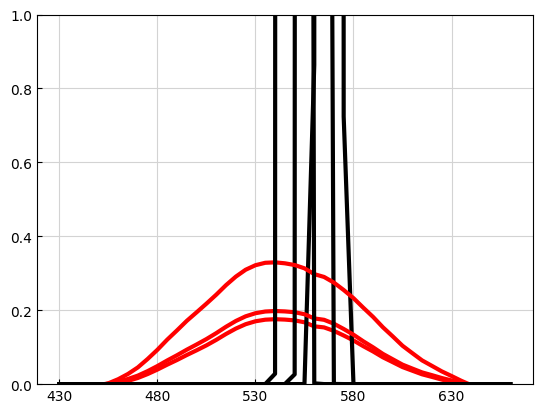

In [122]:
fig, ax = plt.subplots()
for i in range(len(all_patches_center_pts)):
# for i in range(0,1):
    plt.ylim([0,1])
    argmax_idx = np.argmax(ref_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]])
    
    max_val = ref_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]].max()
    
    ax.plot(new_wvls*1e9, ref_reshape[all_patches_center_pts[i,1],all_patches_center_pts[i,0]], label = peak_wvl[i], linewidth = 3, c = 'red')
    # ax.plot(new_wvls*1e9, band_pass_transmission[i]/band_pass_transmission[i].max(), c = 'black', linewidth = 3)
    ax.plot(new_wvls*1e9, band_pass_transmission[i], c = 'black', linewidth = 3)

    ax.set_xticks(x_axis)
    ax.tick_params(direction='in')
    plt.grid(color = 'lightgray')
    # plt.legend()
    print('%dnm'%peak_wvl[i], new_wvls[argmax_idx]*1e9)

### RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


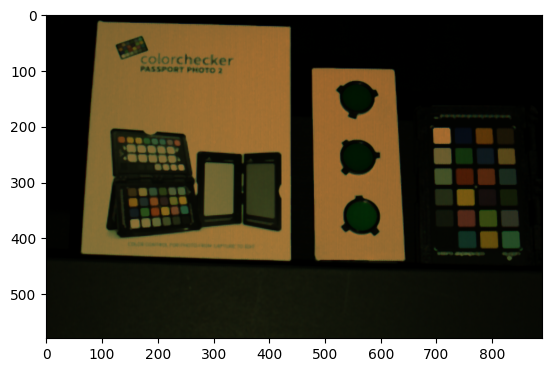

In [ ]:
rgb_img = ref@CRF

plt.figure()
plt.imshow(rgb_img.reshape(cam_H, cam_W,3)*0.02)
# plt.savefig('./rgb.png')